[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/examples/mapelites.ipynb)

# Optimizing with MAP-Elites in Jax

This notebook shows how to use QDax to find diverse and performing controllers in MDPs with [MAP-Elites](https://arxiv.org/abs/1504.04909).
It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create an emitter
- how to create a Map-elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process
- how to save/load a repertoire

In [1]:
#@title Installs and Imports
# !pip install ipympl |tail -n 1
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()

import os

from IPython.display import clear_output
import functools
import time

import jax
import jax.numpy as jnp

try:
    import brax
except:
    # !pip install git+https://github.com/google/brax.git@v0.0.15 |tail -n 1
    import brax

try:
    import qdax
except:
    # !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax


from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
from qdax import environments
from qdax.tasks.brax_envs import scoring_function_brax_envs as scoring_function
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.plotting import plot_map_elites_results

from qdax.utils.metrics import CSVLogger, default_qd_metrics

from jax.flatten_util import ravel_pytree

from IPython.display import HTML
from brax.io import html



if "COLAB_TPU_ADDR" in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()


clear_output()

%matplotlib inline

In [2]:
#@title QD Training Definitions Fields
#@markdown ---
batch_size = 1000 #@param {type:"number"}
env_name = 'halfcheetah_uni'#@param['ant_uni', 'hopper_uni', 'walker2d_uni', 'halfcheetah_uni', 'humanoid_uni', 'ant_omni', 'humanoid_omni']
episode_length = 100 #@param {type:"integer"}
num_iterations = 1000 #@param {type:"integer"}
seed = 42 #@param {type:"integer"}
policy_hidden_layer_sizes = (64, 64) #@param {type:"raw"}
iso_sigma = 0.005 #@param {type:"number"}
line_sigma = 0.05 #@param {type:"number"}
num_init_cvt_samples = 50000 #@param {type:"integer"}
num_centroids = 1024 #@param {type:"integer"}
min_bd = 0. #@param {type:"number"}
max_bd = 1.0 #@param {type:"number"}
#@markdown ---

## Init environment, policy, population params, init states of the env

Define the environment in which the policies will be trained. In this notebook, we focus on controllers learning to move a robot in a physical simulation. We also define the shared policy, that every individual in the population will use. Once the policy is defined, all individuals are defined by their parameters, that corresponds to their genotype.

In [3]:
# Init environment
env = environments.create(env_name, episode_length=episode_length)

# Init a random key
random_key = jax.random.PRNGKey(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
    # activation=jnp.sort,
)

# Init population of controllers
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num=batch_size)
fake_batch = jnp.zeros(shape=(batch_size, env.observation_size))
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)


# Create the initial environment states
random_key, subkey = jax.random.split(random_key)
keys = jnp.repeat(jnp.expand_dims(subkey, axis=0), repeats=batch_size, axis=0)
reset_fn = jax.jit(jax.vmap(env.reset))
init_states = reset_fn(keys)

## Define the way the policy interacts with the env

Now that the environment and policy has been defined, it is necessary to define a function that describes how the policy must be used to interact with the environment and to store transition data.

In [4]:
# Define the fonction to play a step with the policy in the environment
def play_step_fn(
  env_state,
  policy_params,
  random_key,
):
    """
    Play an environment step and return the updated state and the transition.
    """

    actions = policy_network.apply(policy_params, env_state.obs)
    
    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        actions=actions,
        truncations=next_state.info["truncation"],
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
    )

    return next_state, policy_params, random_key, transition

## Define the scoring function and the way metrics are computed

The scoring function is used in the evaluation step to determine the fitness and behavior descriptor of each individual. 

In [5]:
# Prepare the scoring function
bd_extraction_fn = environments.behavior_descriptor_extractor[env_name]
scoring_fn = functools.partial(
    scoring_function,
    init_states=init_states,
    episode_length=episode_length,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=reward_offset * episode_length,
)

## Define the emitter

The emitter is used to evolve the population at each mutation step.

In [6]:
# Define emitter
variation_fn = functools.partial(
    isoline_variation, iso_sigma=iso_sigma, line_sigma=line_sigma
)
mixing_emitter = MixingEmitter(
    mutation_fn=None, 
    variation_fn=variation_fn, 
    variation_percentage=1.0, 
    batch_size=batch_size
)

## Instantiate and initialise the MAP Elites algorithm

In [10]:
# Instantiate MAP-Elites
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=mixing_emitter,
    metrics_function=metrics_function,
)

# Compute the centroids
centroids, random_key = compute_cvt_centroids(
    num_descriptors=env.behavior_descriptor_length,
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_bd,
    maxval=max_bd,
    random_key=random_key,
)

# Compute initial repertoire and emitter state
repertoire, emitter_state, random_key = map_elites.init(init_variables, centroids, random_key)

/home/paul/Dev/QDax/qdax/core/map_elites.py:80: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


## Launch MAP-Elites iterations

In [11]:
log_period = 10
num_loops = int(num_iterations / log_period)

csv_logger = CSVLogger(
    "mapelites-logs.csv",
    header=["loop", "iteration", "qd_score", "max_fitness", "coverage", "time"]
)
all_metrics = {}

from tqdm import tqdm
# main loop
map_elites_scan_update = map_elites.scan_update
for i in tqdm(range(num_loops)):
    start_time = time.time()
    # main iterations
    (repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
        map_elites_scan_update,
        (repertoire, emitter_state, random_key),
        (),
        length=log_period,
    )
    timelapse = time.time() - start_time

    # log metrics
    logged_metrics = {"time": timelapse, "loop": 1+i, "iteration": 1 + i*log_period}
    for key, value in metrics.items():
        # take last value
        logged_metrics[key] = value[-1]

        # take all values
        if key in all_metrics.keys():
            all_metrics[key] = jnp.concatenate([all_metrics[key], value])
        else:
            all_metrics[key] = value

    csv_logger.log(logged_metrics)

100%|██████████| 100/100 [00:13<00:00,  7.62it/s]


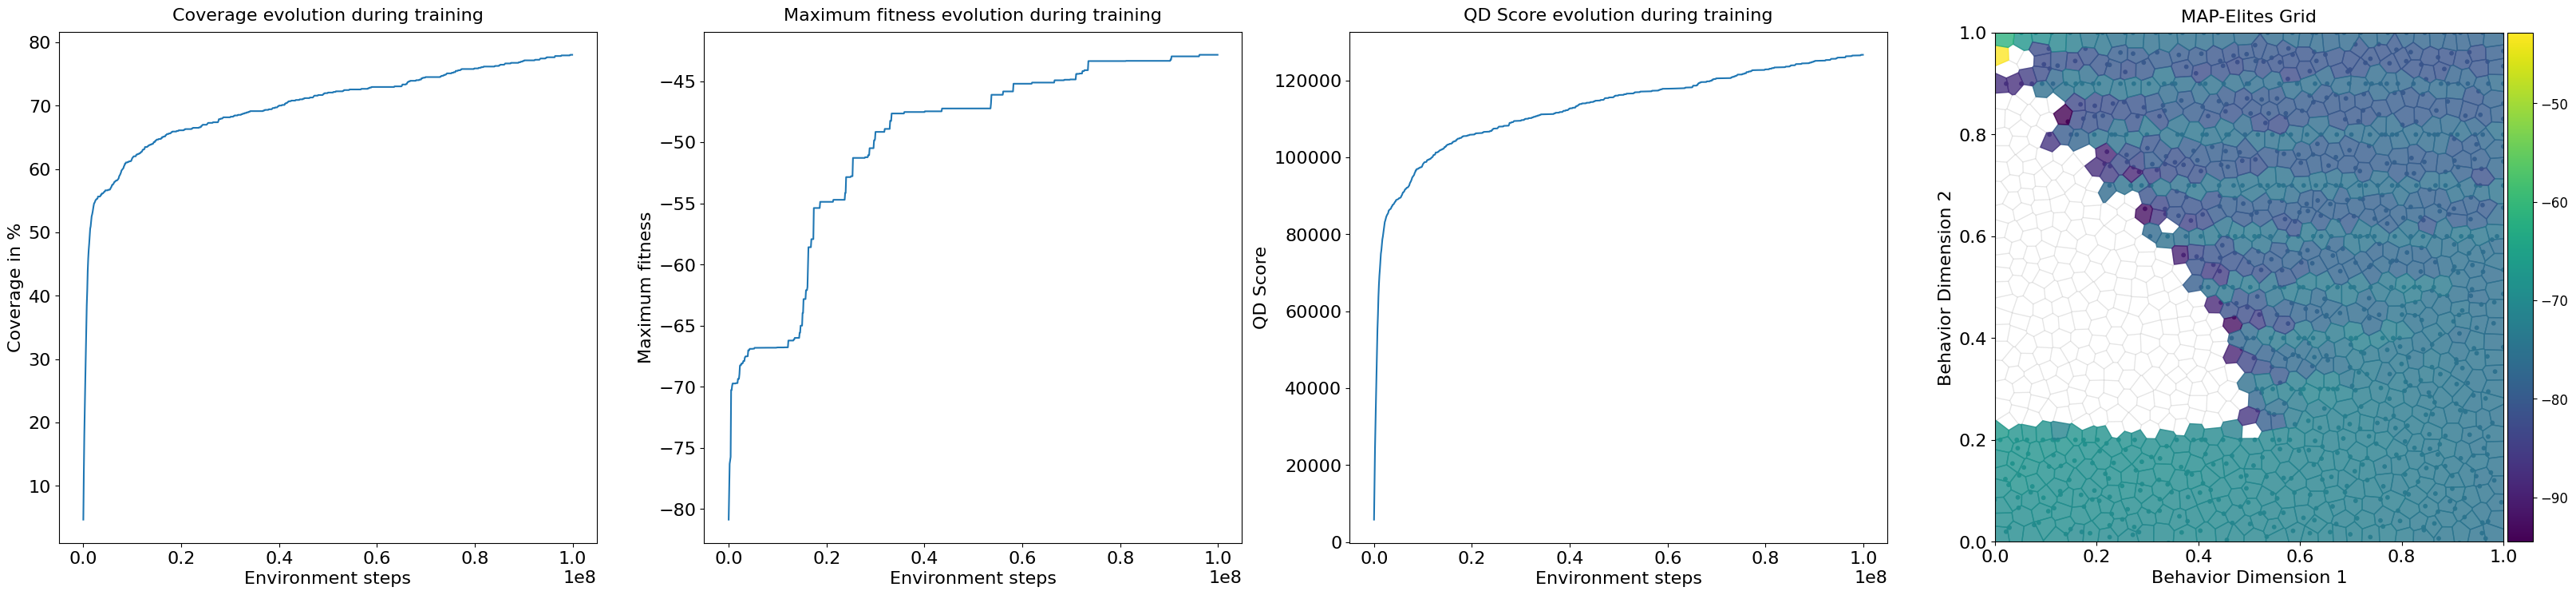

In [12]:
#@title Visualization

# create the x-axis array
env_steps = jnp.arange(num_iterations) * episode_length * batch_size

# create the plots and the grid
fig, axes = plot_map_elites_results(env_steps=env_steps, metrics=all_metrics, repertoire=repertoire, min_bd=min_bd, max_bd=max_bd)

In [11]:
fig.savefig("plots/groupsort.png", dpi=300, bbox_inches="tight")

# How to save/load a repertoire

The following cells show how to save or load a repertoire of individuals and add a few lines to visualise the best performing individual in a simulation.

## Load the final repertoire

In [18]:
repertoire_path = "./last_repertoire/"
os.makedirs(repertoire_path, exist_ok=True)
repertoire.save(path=repertoire_path)

## Build the reconstruction function

In [19]:
# Init population of policies
random_key, subkey = jax.random.split(random_key)
fake_batch = jnp.zeros(shape=(env.observation_size,))
fake_params = policy_network.init(subkey, fake_batch)

_, reconstruction_fn = ravel_pytree(fake_params)

## Use the reconstruction function to load and re-create the repertoire

In [20]:
repertoire = MapElitesRepertoire.load(reconstruction_fn=reconstruction_fn, path=repertoire_path)

## Get the best individual of the repertoire

In [21]:
best_idx = jnp.argmax(repertoire.fitnesses)
best_fitness = jnp.max(repertoire.fitnesses)
best_bd = repertoire.descriptors[best_idx]

In [22]:
print(
    f"Best fitness in the repertoire: {best_fitness:.2f}\n",
    f"Behavior descriptor of the best individual in the repertoire: {best_bd}\n",
    f"Index in the repertoire of this individual: {best_idx}\n"
)

Best fitness in the repertoire: 252.76
 Behavior descriptor of the best individual in the repertoire: [0.44 0.63]
 Index in the repertoire of this individual: 940



In [23]:
my_params = jax.tree_util.tree_map(
    lambda x: x[best_idx],
    repertoire.genotypes
)

## Play some steps in the environment

In [24]:
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(policy_network.apply)

In [25]:
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
while not state.done:
    rollout.append(state)
    action = jit_inference_fn(my_params, state.obs)
    state = jit_env_step(state, action)

print(f"The trajectory of this individual contains {len(rollout)} transitions.")

The trajectory of this individual contains 100 transitions.


In [26]:
HTML(html.render(env.sys, [s.qp for s in rollout[:500]]))

In [29]:
content = html.render(env.sys, [s.qp for s in rollout[:500]])
with open("trajectory.html", "w") as f:
    f.write(content)

In [30]:
import wandb
wandb.init(project="test", entity="sureli")
wandb.log({"custom_string": wandb.Html(content)})

/home/paul/miniconda3/envs/qdax_env/lib/python3.9/site-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/paul/miniconda3/envs/qdax_env/lib/python3.9/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(
wandb: Currently logged in as: ptemplier (sureli). Use `wandb login --relogin` to force relogin
/home/paul/miniconda3/envs/qdax_env/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:47: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPyt

In [31]:
wandb.log({"best_agent": wandb.Html(content)})